In [1]:
# import libraries

import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchsummary
import segmentation_models_pytorch as smp
from sklearn import model_selection

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
from osgeo import gdal, ogr
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

from PIL import Image
from tqdm import tqdm
from natsort.natsort import natsorted
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import random

import HelperFunctions
from module import SpaceNetBuildingDetection
from arguments import get_args
args = get_args()
torch.cuda.empty_cache()

Total images found in images folder: 56
Total files found in labels_geo folder: 56


Text(0.5, 1.0, 'Image4: L15-1672E-1207N_6691_3363_13.tif')

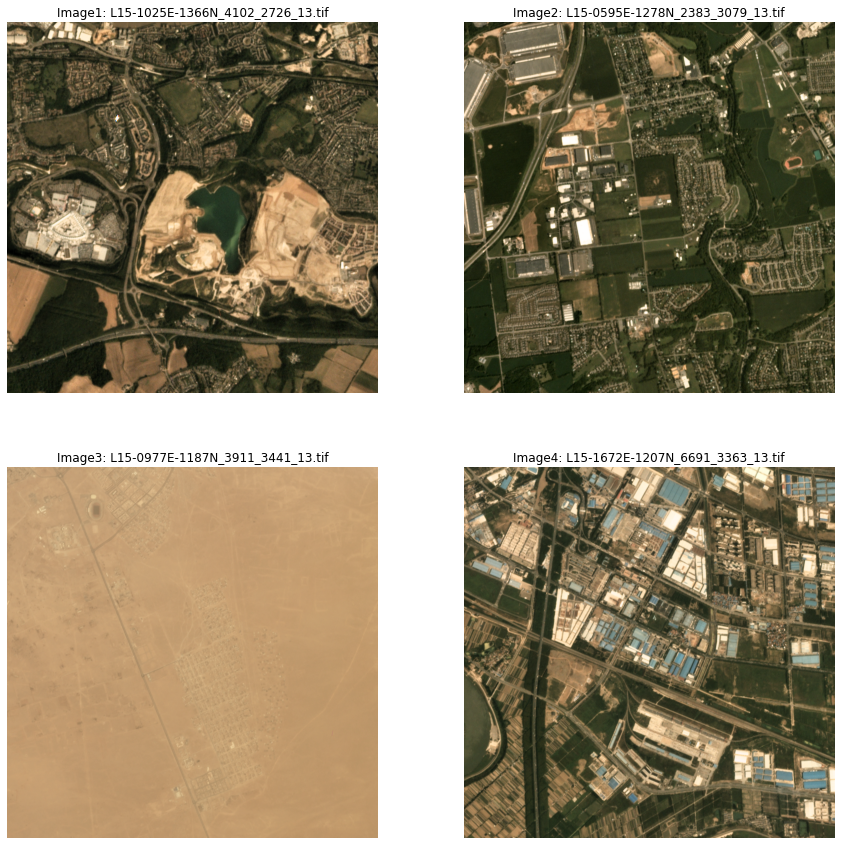

In [18]:
# display random satellite images 

raster_images = natsorted(os.listdir(args.raster_path))
labels_pix = natsorted(os.listdir(args.vector_path))
labels_geo = natsorted(os.listdir(args.label_geo_path))
print(f"Total images found in images folder: {len(raster_images)}")
print(f"Total files found in labels_geo folder: {len(labels_geo)}")

#indexes = []
indexes = [random.randint(0,len(raster_images)-1) for _ in range(5)]
# for _ in range(5):
#     idx = random.randint(0,len(raste'r_images)-1) 
#     indexes.append(idx)

raster_path1 = args.raster_path + raster_images[indexes[0]]
raster_path2 = args.raster_path + raster_images[indexes[1]]
raster_path3 = args.raster_path + raster_images[indexes[2]]
raster_path4 = args.raster_path + raster_images[indexes[3]]

img0 = Image.open(raster_path1)
img0 = np.array(img0)
img1 = Image.open(raster_path2)
img1 = np.array(img1)
img2 = Image.open(raster_path3)
img2 = np.array(img2)
img3 = Image.open(raster_path4)
img3 = np.array(img3)

fig = plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(img0)
plt.axis('off')
plt.title(f"Image1: {raster_images[indexes[0]].split('mosaic_')[1]}")

plt.subplot(222)
plt.imshow(img1)
plt.axis('off')
plt.title(f"Image2: {raster_images[indexes[1]].split('mosaic_')[1]}")

plt.subplot(223)
plt.imshow(img2)
plt.axis('off')
plt.title(f"Image3: {raster_images[indexes[2]].split('mosaic_')[1]}")

plt.subplot(224)
plt.imshow(img3)
plt.axis('off')
plt.title(f"Image4: {raster_images[indexes[3]].split('mosaic_')[1]}")

<h2><b>Displaying Raster Image and its Mask</b></h2>

#### The information about the building labels and its coordinates for each raster image is provided in its corresponding <i>geojson</i> file. The file can be explored using <b>geopandas</b> which is a useful tool for exploring the number of different geometries and the geometrical information for each individual geometry in a file.

#### From the below cell, we find that all the vector files have a single geometry type i.e. <b>Polygon</b>. Polygons are used to draw the edges of the buildings in the provided satellite images. The x and y coordinates of each point of the polygon is defined in terms of latitude and longitude with respect to the geographical location of the image. 

In [41]:
vectors = natsorted(os.listdir(args.label_geo_path))
geometries = []
for v in vectors:
    vector_df = gpd.read_file(args.label_geo_path + v)
    geometry = vector_df.geom_type.unique()
    if geometry.size > 0:
        geometries.append(geometry[0])
print(f"Unique geometries: {np.unique(np.array(geometries))}")
print(f"Geometry: {vector_df.geometry.iloc[0]}")

Unique geometries: ['Polygon']
Geometry: POLYGON ((144.9519009084438 -37.51487087526034, 144.9521576010493 -37.51487087526034, 144.9521576010493 -37.5149839908158, 144.9519009084438 -37.5149839908158, 144.9519009084438 -37.51487087526034))


global_monthly_2019_08_mosaic_L15-0331E-1257N_1327_3160_13.tif


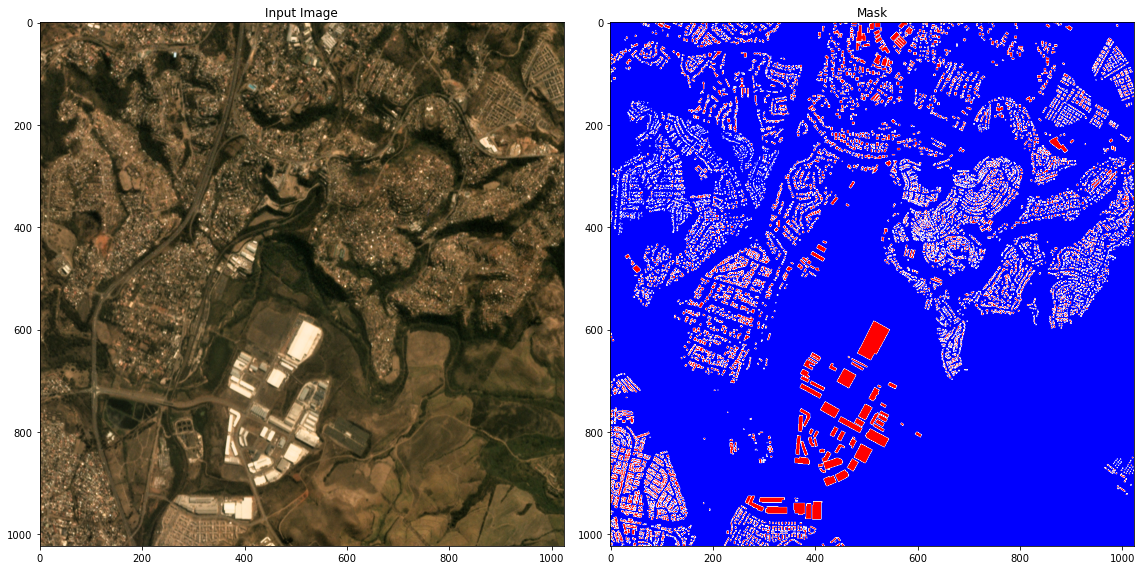

In [6]:
## Generate Raster Mask 
def plot_raster_mask(rasterPath, geoJsonPath, verbose=False):
    raster_images = natsorted(os.listdir(rasterPath))
    dummy_labels = natsorted(os.listdir(geoJsonPath))
    idx = random.randint(0,len(raster_images)-1) # 48
    print(raster_images[0])
    raster_path = rasterPath + raster_images[idx]
    geojson_path = geoJsonPath + dummy_labels[idx]

    img0 = Image.open(raster_path)
    img0 = np.array(img0)

    pixel_coord, _ = HelperFunctions.geojson_to_pixel_arr(raster_path, geojson_path, 1, verbose=verbose)

    maskImage0 = HelperFunctions.create_poly_mask(raster_path, geojson_path, npDistFileName='tmp/.tmp.tiff', noDataValue=0, burn_values=255)

    ## Plot input image and mask
    poly_face_color='orange'
    poly_edge_color='red'
    poly_nofill_color='blue'
    cmap='bwr'

    patches = []
    patches_nofill = []
    if len(pixel_coord) > 0:
        for coord in pixel_coord:
            #print(coord)
            patches_nofill.append(Polygon(coord, facecolor=poly_nofill_color, 
                                            edgecolor=poly_edge_color, lw=3))
            patches.append(Polygon(coord, edgecolor=poly_edge_color, fill=True, 
                                    facecolor=poly_face_color))
        pc = PatchCollection(patches, alpha=0.25, match_original=True)

    # generate image
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,8))

    # ax0 - input image
    ax0.imshow(img0)
    if len(patches) > 0:
        ax0.add_collection(pc)
    ax0.set_title('Input Image') 

    # ax1 - mask image
    ax1.imshow(maskImage0, cmap=cmap)
    ax1.set_title('Mask')    
            
    plt.tight_layout()
    plt.show()

plot_raster_mask(args.raster_path, args.label_geo_path, verbose=False)

In [7]:
def filterRasterImages(rasterDir, vectorDir, threshold=0.8):
    """
    This function removes those images (black / empty)
    which has a mean pixel value of less than 0.2
    :param rasterDir: path of raster dir
    :param vectorDir: path of geojson files dir
    :output: filtered list of raster and vecotor filename
    """
    rasterImages = natsorted(os.listdir(rasterDir))
    vectors = natsorted(os.listdir(vectorDir))
    rasterFiltered = [] 
    vectorFiltered = [] 
    for rI, v in zip(rasterImages, vectors):
        temp0 = Image.open(rasterDir + rI)
        temp0 = np.array(temp0)
        if temp0.mean() > (1-threshold):
            rasterFiltered.append(rI)
            vectorFiltered.append(v)
        else:
            pass
    return rasterFiltered, vectorFiltered

def build_labels(args, raster_images, vectors):
    """
    This function generates output mask images representing 
    geographical features for each input raster image and
    its respective geospatial data from the geojson file.
    The build mask is saved at the output dir.
    :param args: arguments
    :param raster_images: filtered raster images
    :param vectors: filtered vectors
    """
    os.makedirs(args.output_path, exist_ok=True)
    print(f"\nTotal geofiles found {len(raster_images)}.\nPrepaing to build images..")
    for (raster, vector) in zip(raster_images, vectors):
        raster_path = args.raster_path + "global_monthly_2019_08_mosaic_" + raster.split('mosaic_')[1]
        vector_path = args.label_geo_path + "global_monthly_2019_08_mosaic_" + vector.split('mosaic_')[1]
        output_path = args.output_path + "mask_" + raster.split('mosaic_')[1]

        HelperFunctions.create_poly_mask(
            raster_path,
            vector_path,
            npDistFileName=output_path,
            noDataValue=0,
            burn_values=255
        )
    print("Build complete")


In [12]:
rasterImages, vectors = filterRasterImages(args.raster_path, args.vector_path)
build_labels(args, rasterImages, vectors)


Total geofiles found 55.
Prepaing to build images..
Build complete


<center>
<h2><b>U-Net Architecture</b></h2>
</center>

<br>
<br>
<br>

<center>
<img src="media/u-net-architecture.png" alt="Drawing" style="width: 750px;"/> 
<figcaption>U-Net Architecture</figcaption>
</center>


- #### U-Nets have two parts: An **Encoder** and a **Decoder** 
- #### **Encoder:** An encoder is similar to any normal convolution network that contains a series of down convolution layers with batch normalization and max pooling layers.
- #### **Decoder:** A decoder consists of up-convolution layers. In up-convolutions (transposed convolutions), filters are used that when apllied to a small image, creates a enlarged verion of the image. In PyTorch, *ConvTranspose2d* is used for this operation.
- #### It must be noted that, up-convolutions is not the same as up-sampling. Up-ampling is an easy process in which a functionn is applied to an image to resize it. In up-convolutions, the filters are *learned*. Some parts of the encoder ar taken as input to some part of the decoders which can also be seen in the above image. 
- #### As already mentioned, the encoder part of the U-Net is a simple convolution network. Therefore, it can be replaced with any network such as *ResNet*. The replacement can also be done with pretrained weights.
- #### Therefore for this task, a **ResNet** based encoder is used which is **pretrained** on **ImageNet** dataset and a generic decoder is used.
- #### *Segmentation Models Pytorch* is used for implementing a ResNet based U-Net (encoder pretrained ImageNet) for segmenting building polygons from the input raster images.

In [4]:
# Define Training Function

def train(dataset, data_loader, model, criterion, optimizer, args):
    """
    Training loop
    :param dataset: dataset class (SIIMDataset)
    :param data_loader: torch dataset loader
    :param criterion: loss funtion
    :param optimizer: Adam
    :param args: arguments 
    """
    model.train()
    avg_loss = []

    num_batches = int(len(dataset) / data_loader.batch_size)

    # tqdm to track the progress
    tq = tqdm(data_loader, total=num_batches)
    
    for batch in tq:
        # get images and masks from the data
        inputs = batch["image"]
        targets = batch["mask"]

        inputs = inputs.to(args.device, dtype=torch.float)
        targets = targets.to(args.device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)

        # calculate the loss
        loss = criterion(outputs, targets) 
        avg_loss.append(loss.item())
        loss.backward()
        # if you require mixed precision 
        # comment loss.backward() and use  
        # the following lines for backpropagating
        # ->with amp.scale_loss(loss, optimizer) as scaled_loss:
        # -->scaled_loss.backward()

        optimizer.step()
    
    tq.close()

    return avg_loss

In [5]:
# validation function

def evaluate(dataset, data_loader, model, args):
    """
    Evaluates the model
    :param dataset: dataset class (SIIMDATASET)
    :param data_loader: torch dataset loader
    :param model: model
    :param args: arguments
    """
    # model in eval mode
    model.eval()
    valid_losses = []

    num_batches = int(len(dataset) / data_loader.batch_size)
    
    # initialize tqdm
    tq = tqdm(data_loader, total=num_batches)

    with torch.no_grad():
        for batch in tq:
            inputs = batch["image"]
            targets = batch["mask"]
            inputs = inputs.to(args.device, dtype=torch.float)
            targets = targets.to(args.device, dtype=torch.float)
            output = model(inputs)
            loss = criterion(output, targets)
            valid_losses.append(loss)
    
    # closing tqdm 
    tq.close()
    # return avg loss over all batches
    return valid_losses

In [6]:
df_training = pd.DataFrame()
df_testing = pd.DataFrame()

image_ids = [fn.split('mosaic_')[1].split('.')[0] for fn in rasterImages]
df_training["ImageId"], df_testing["ImageId"] = image_ids[0:len(image_ids)-3], image_ids[len(image_ids)-3:]

# splitting the data into training and validation
df_train, df_valid = model_selection.train_test_split(
    df_training, random_state=42, test_size=0.1
)

# training and validation images lists / arrays
training_images = df_train.ImageId.values
validation_images = df_valid.ImageId.values

# fetch unet model from sementation models
# with specified encoder arcitecture
model = smp.Unet(
    encoder_name = args.encoder,
    encoder_weights = args.encoder_weights,
    classes = 1,
    activation = None
)

# send model to device
model.to(args.device)

# save model summary into a text file
with open(args.model_output + "model_summary.txt", 'w') as file:
    report, _ = torchsummary.summary_string(model, (3,args.resize_img,args.resize_img))
    file.writelines(report)

# segmentation model provides you with a preprocessing 
# function that can be used for normalizing images
# normalization is only applied on images and not on masks

prep_fn = smp.encoders.get_preprocessing_fn(
    args.encoder, 
    args.encoder_weights
)

# init training dataset
# transform is True for training dataset
train_dataset = SpaceNetBuildingDetection(
    training_images,
    arguments=args,
    transform=args.img_augmentation,
    preprocessing_fn=prep_fn,
)

# wrap training dataset in torch's dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.train_batch_size,
    shuffle=True,
    num_workers=1
)

# initialize the validation dataset
# Disabling augmentation.
valid_dataset = SpaceNetBuildingDetection(
    validation_images,
    arguments=args,
    transform=False,
    preprocessing_fn=prep_fn,
)

# wrap validation dataset in torch's dataloader
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=args.valid_batch_size,
    shuffle=True,
    num_workers=1
)

# Define the criterion for loss
criterion = nn.BCEWithLogitsLoss()

# adam optimizer for faster convergence
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

#reduce learning rate when we reach a plateau on loss
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=3, verbose=True
)

# the model and optimizer is wrapped with 
# If you want to use NVIDIA's apex for mixed precision
#  training uncomment the following lines

# model, optimizer = amp.initialize(
#     model, optimizer, opt_level="O1", verbosity=0
# )

# if you have more than 1 GPU use all of them
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# some logging 
print(f"Training batch size: {args.train_batch_size}")
print(f"Validation batch size: {args.valid_batch_size}")
print(f"Image augmentation: {args.img_augmentation}")
print(f"Epochs: {args.n_epochs}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(valid_dataset)}")
print(f"Encoder Type: {args.encoder}")
print(f"Using pretrained weights from: {args.encoder_weights}")

train_losses = []
valid_losses = []

for epoch in range(args.n_epochs):
    print(f"\nTraining Epoch: {epoch}")
    train_loss = train(
        train_dataset,
        train_loader,
        model,
        criterion,
        optimizer,
        args
    )
    print(f"\nValidation Epoch: {epoch}")
    valid_loss = evaluate(
        valid_dataset,
        valid_loader,
        model,
        args
    )
    
    train_losses.append(torch.tensor(train_loss).mean())
    valid_losses.append(torch.tensor(valid_loss).mean())

    print(f"Training Mean Loss: {torch.tensor(train_loss).mean()}")
    print(f"Validation Mean Loss: {torch.tensor(valid_loss).mean()}")
    scheduler.step(args.scheduler_rate)
    print("\n")

Training batch size: 1
Validation batch size: 1
Epochs: 50
Number of training images: 46
Number of validation images: 6
Encoder Type: resnet18
Using pretrained weights from: imagenet

Training Epoch: 0


100%|██████████| 46/46 [00:22<00:00,  2.01it/s]



Validation Epoch: 0


100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Training Mean Loss: 0.5718681216239929
Validation Mean Loss: 0.4534362256526947



Training Epoch: 1


100%|██████████| 46/46 [00:22<00:00,  2.07it/s]



Validation Epoch: 1


100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Training Mean Loss: 0.38597434759140015
Validation Mean Loss: 0.35522541403770447



Training Epoch: 2


100%|██████████| 46/46 [00:22<00:00,  2.07it/s]



Validation Epoch: 2


100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Training Mean Loss: 0.32135310769081116
Validation Mean Loss: 0.3140636682510376



Training Epoch: 3


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 3


100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Training Mean Loss: 0.2870310842990875
Validation Mean Loss: 0.2706964910030365



Training Epoch: 4


100%|██████████| 46/46 [00:22<00:00,  2.05it/s]



Validation Epoch: 4


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Training Mean Loss: 0.2620711922645569
Validation Mean Loss: 0.246696338057518
Epoch     5: reducing learning rate of group 0 to 1.0000e-05.



Training Epoch: 5


100%|██████████| 46/46 [00:22<00:00,  2.05it/s]



Validation Epoch: 5


100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Training Mean Loss: 0.24867625534534454
Validation Mean Loss: 0.24524392187595367



Training Epoch: 6


100%|██████████| 46/46 [00:22<00:00,  2.06it/s]



Validation Epoch: 6


100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Training Mean Loss: 0.2459990680217743
Validation Mean Loss: 0.2572300136089325



Training Epoch: 7


100%|██████████| 46/46 [00:22<00:00,  2.06it/s]



Validation Epoch: 7


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Training Mean Loss: 0.2434788942337036
Validation Mean Loss: 0.2431449145078659



Training Epoch: 8


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 8


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Training Mean Loss: 0.24104292690753937
Validation Mean Loss: 0.23902899026870728
Epoch     9: reducing learning rate of group 0 to 1.0000e-06.



Training Epoch: 9


100%|██████████| 46/46 [00:22<00:00,  2.05it/s]



Validation Epoch: 9


100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Training Mean Loss: 0.23942290246486664
Validation Mean Loss: 0.23744530975818634



Training Epoch: 10


100%|██████████| 46/46 [00:22<00:00,  2.03it/s]



Validation Epoch: 10


100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


Training Mean Loss: 0.23915201425552368
Validation Mean Loss: 0.24207989871501923



Training Epoch: 11


100%|██████████| 46/46 [00:22<00:00,  2.02it/s]



Validation Epoch: 11


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Training Mean Loss: 0.23888817429542542
Validation Mean Loss: 0.2371714562177658



Training Epoch: 12


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 12


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Training Mean Loss: 0.23861806094646454
Validation Mean Loss: 0.24121476709842682
Epoch    13: reducing learning rate of group 0 to 1.0000e-07.



Training Epoch: 13


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 13


100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


Training Mean Loss: 0.23843547701835632
Validation Mean Loss: 0.2425323724746704



Training Epoch: 14


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 14


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Training Mean Loss: 0.23840777575969696
Validation Mean Loss: 0.23801909387111664



Training Epoch: 15


100%|██████████| 46/46 [00:22<00:00,  2.05it/s]



Validation Epoch: 15


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Training Mean Loss: 0.23837867379188538
Validation Mean Loss: 0.24512654542922974



Training Epoch: 16


100%|██████████| 46/46 [00:22<00:00,  2.05it/s]



Validation Epoch: 16


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Training Mean Loss: 0.23835019767284393
Validation Mean Loss: 0.2432413548231125
Epoch    17: reducing learning rate of group 0 to 1.0000e-08.



Training Epoch: 17


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 17


100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Training Mean Loss: 0.23833005130290985
Validation Mean Loss: 0.24456024169921875



Training Epoch: 18


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 18


100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Training Mean Loss: 0.23832698166370392
Validation Mean Loss: 0.24096129834651947



Training Epoch: 19


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 19


100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


Training Mean Loss: 0.2383238822221756
Validation Mean Loss: 0.24231193959712982



Training Epoch: 20


100%|██████████| 46/46 [00:22<00:00,  2.03it/s]



Validation Epoch: 20


100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Training Mean Loss: 0.2383207231760025
Validation Mean Loss: 0.24255794286727905



Training Epoch: 21


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 21


100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Training Mean Loss: 0.23831744492053986
Validation Mean Loss: 0.24559366703033447



Training Epoch: 22


100%|██████████| 46/46 [00:22<00:00,  2.05it/s]



Validation Epoch: 22


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Training Mean Loss: 0.23831410706043243
Validation Mean Loss: 0.2411186248064041



Training Epoch: 23


100%|██████████| 46/46 [00:22<00:00,  2.05it/s]



Validation Epoch: 23


100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Training Mean Loss: 0.2383108288049698
Validation Mean Loss: 0.23997336626052856



Training Epoch: 24


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 24


100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Training Mean Loss: 0.23830747604370117
Validation Mean Loss: 0.24693524837493896



Training Epoch: 25


100%|██████████| 46/46 [00:22<00:00,  2.04it/s]



Validation Epoch: 25


100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


Training Mean Loss: 0.23830409348011017
Validation Mean Loss: 0.242214635014534



Training Epoch: 26


100%|██████████| 46/46 [00:22<00:00,  2.05it/s]



Validation Epoch: 26


100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Training Mean Loss: 0.23830075562000275
Validation Mean Loss: 0.2362283617258072



Training Epoch: 27


100%|██████████| 46/46 [00:22<00:00,  2.01it/s]



Validation Epoch: 27


100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Training Mean Loss: 0.2382972091436386
Validation Mean Loss: 0.25173914432525635



Training Epoch: 28


100%|██████████| 46/46 [00:22<00:00,  2.01it/s]



Validation Epoch: 28


100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Training Mean Loss: 0.23829373717308044
Validation Mean Loss: 0.24323083460330963



Training Epoch: 29


100%|██████████| 46/46 [00:22<00:00,  2.01it/s]



Validation Epoch: 29


100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Training Mean Loss: 0.2382902204990387
Validation Mean Loss: 0.2460242062807083



Training Epoch: 30


100%|██████████| 46/46 [00:22<00:00,  2.01it/s]



Validation Epoch: 30


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Training Mean Loss: 0.23828665912151337
Validation Mean Loss: 0.24516570568084717



Training Epoch: 31


100%|██████████| 46/46 [00:22<00:00,  2.00it/s]



Validation Epoch: 31


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Training Mean Loss: 0.23828311264514923
Validation Mean Loss: 0.2490113526582718



Training Epoch: 32


100%|██████████| 46/46 [00:23<00:00,  1.97it/s]



Validation Epoch: 32


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


Training Mean Loss: 0.23827946186065674
Validation Mean Loss: 0.23994195461273193



Training Epoch: 33


100%|██████████| 46/46 [00:25<00:00,  1.81it/s]



Validation Epoch: 33


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Training Mean Loss: 0.2382759153842926
Validation Mean Loss: 0.2487495392560959



Training Epoch: 34


100%|██████████| 46/46 [00:25<00:00,  1.78it/s]



Validation Epoch: 34


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Training Mean Loss: 0.23827223479747772
Validation Mean Loss: 0.24639903008937836



Training Epoch: 35


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]



Validation Epoch: 35


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Mean Loss: 0.23826864361763
Validation Mean Loss: 0.24217991530895233



Training Epoch: 36


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]



Validation Epoch: 36


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Training Mean Loss: 0.23826482892036438
Validation Mean Loss: 0.2454921454191208



Training Epoch: 37


100%|██████████| 46/46 [00:25<00:00,  1.81it/s]



Validation Epoch: 37


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Training Mean Loss: 0.2382611185312271
Validation Mean Loss: 0.2379172295331955



Training Epoch: 38


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]



Validation Epoch: 38


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Training Mean Loss: 0.23825739324092865
Validation Mean Loss: 0.2516293227672577



Training Epoch: 39


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]



Validation Epoch: 39


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Training Mean Loss: 0.23825359344482422
Validation Mean Loss: 0.23710781335830688



Training Epoch: 40


100%|██████████| 46/46 [00:25<00:00,  1.81it/s]



Validation Epoch: 40


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


Training Mean Loss: 0.23824989795684814
Validation Mean Loss: 0.24784113466739655



Training Epoch: 41


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]



Validation Epoch: 41


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Training Mean Loss: 0.23824597895145416
Validation Mean Loss: 0.2419673353433609



Training Epoch: 42


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]



Validation Epoch: 42


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Mean Loss: 0.23824214935302734
Validation Mean Loss: 0.2355160266160965



Training Epoch: 43


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]



Validation Epoch: 43


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


Training Mean Loss: 0.23823827505111694
Validation Mean Loss: 0.23977838456630707



Training Epoch: 44


100%|██████████| 46/46 [00:25<00:00,  1.79it/s]



Validation Epoch: 44


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Training Mean Loss: 0.23823443055152893
Validation Mean Loss: 0.24517609179019928



Training Epoch: 45


100%|██████████| 46/46 [00:25<00:00,  1.79it/s]



Validation Epoch: 45


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Training Mean Loss: 0.23823051154613495
Validation Mean Loss: 0.2486969232559204



Training Epoch: 46


100%|██████████| 46/46 [00:24<00:00,  1.85it/s]



Validation Epoch: 46


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Training Mean Loss: 0.23822660744190216
Validation Mean Loss: 0.24526667594909668



Training Epoch: 47


100%|██████████| 46/46 [00:24<00:00,  1.86it/s]



Validation Epoch: 47


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Training Mean Loss: 0.23822271823883057
Validation Mean Loss: 0.2419005185365677



Training Epoch: 48


100%|██████████| 46/46 [00:24<00:00,  1.85it/s]



Validation Epoch: 48


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Training Mean Loss: 0.23821869492530823
Validation Mean Loss: 0.24140161275863647



Training Epoch: 49


100%|██████████| 46/46 [00:24<00:00,  1.85it/s]



Validation Epoch: 49


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

Training Mean Loss: 0.23821480572223663
Validation Mean Loss: 0.2365351766347885




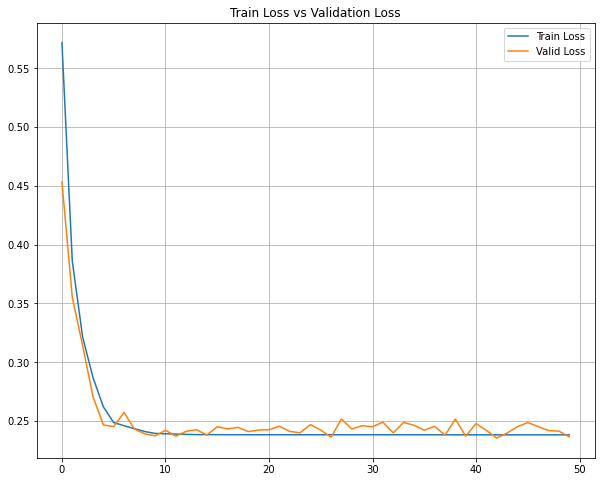

In [7]:
# plotting losses
def plot_losses(trainLoss, validLoss):
    fig = plt.figure(figsize=(10,8))
    plt.subplot(111)
    plt.plot(trainLoss, label='Train Loss')
    plt.plot(validLoss, label='Valid Loss')
    plt.title('Train Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    if args.img_augmentation:
        fn = 'loss_ep_' + str(args.n_epochs)+'_with_augmentation'
    else:
        fn = 'loss_ep_' + str(args.n_epochs)+'_without_augmentation'
    plt.savefig('model_output/' + fn + '.png')
    plt.show()
plot_losses(train_losses, valid_losses)

In [8]:
# Save the model parameters
if args.img_augmentation:
    fn = './params_unet_ep_'+str(args.n_epochs)+'_with_augmentation'+'.pt'
else:
    fn = './params_unet_ep_'+str(args.n_epochs)+'_without_augmentation'+'.pt'
torch.save(model.state_dict(), args.model_output + fn)

In [9]:
# create a test model
test_model = smp.Unet(
    encoder_name = args.encoder,
    encoder_weights = args.encoder_weights,
    classes = 1,
    activation = None
)

test_model = test_model.to(args.device)
test_model.load_state_dict(torch.load(args.model_output + 'params_unet_ep_50_without_augmentation.pt'))
test_model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [10]:
def plot_predictions(imgId):
    test_dataset = SpaceNetBuildingDetection(
        imgId,
        arguments=args,
        transform=False,
        preprocessing_fn=prep_fn,
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=1
    )
    for item in test_loader:
        image = item["image"].to(args.device, dtype=torch.float)
        mask = item["mask"].to(args.device)

        pred = test_model(image)

        input_image = Image.open(args.raster_path + "global_monthly_2019_08_mosaic_" + imgId[0] + '.tif') 
        input_image = np.array(input_image)
        transformed_image = image[0].detach().cpu().numpy()
        pred_mask = pred.detach().cpu().numpy()
        actual_mask = mask.detach().cpu().numpy()

        cmap='bwr'

        fig = plt.figure(figsize=(15,17))
        plt.suptitle(f'ImgId: {imgId[0]}',fontsize=20)
        plt.subplot(221)
        plt.imshow(input_image)
        plt.title("Original Input Image")

        plt.subplot(222)
        plt.imshow(np.squeeze(actual_mask))
        plt.title("True Mask")

        plt.subplot(223)
        plt.imshow(np.squeeze(pred_mask), cmap='seismic')
        plt.title("Predicted Mask")

        plt.tight_layout()
        plt.show()

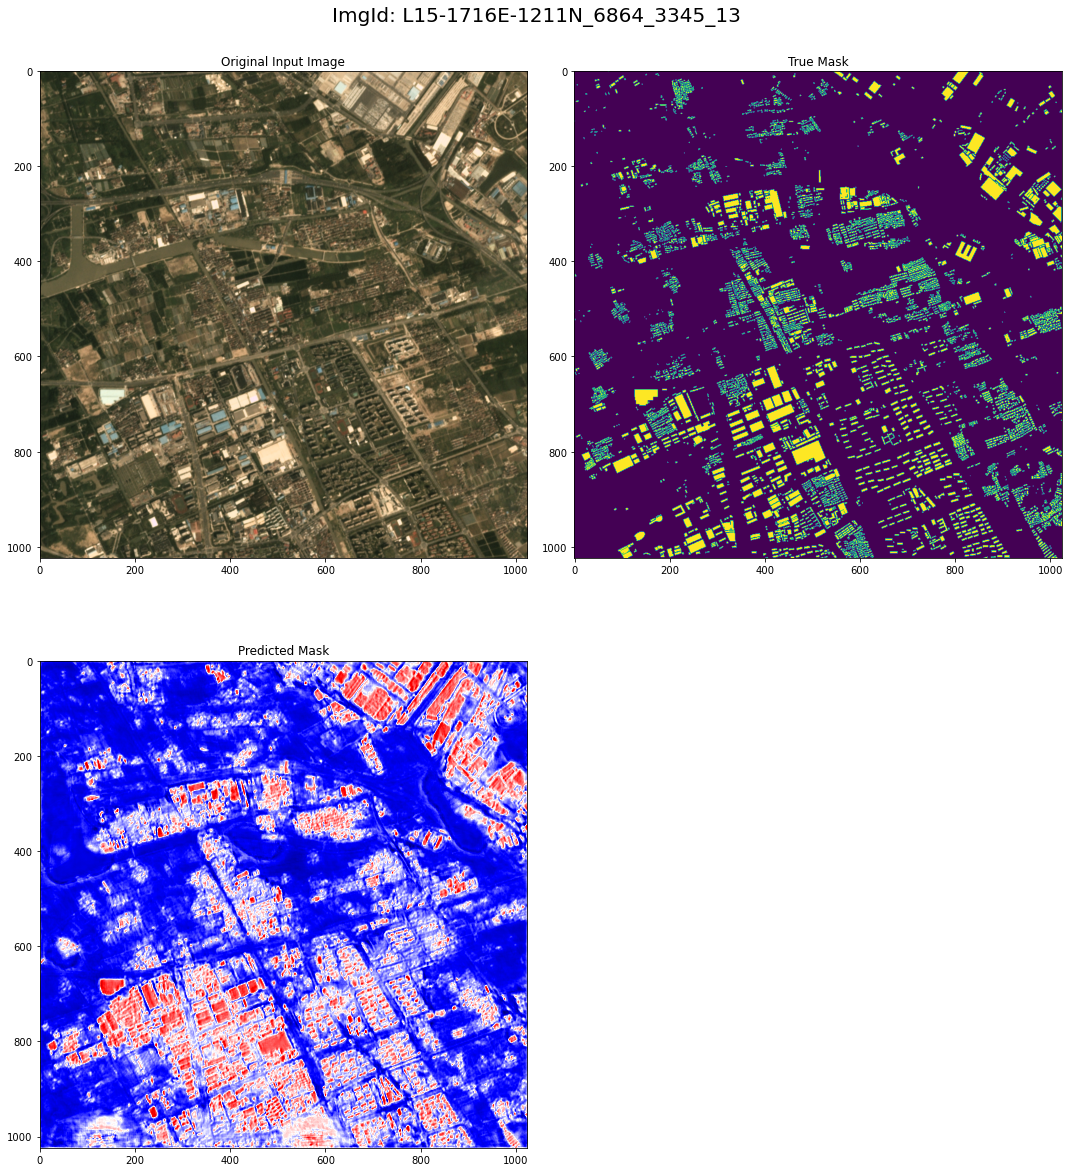

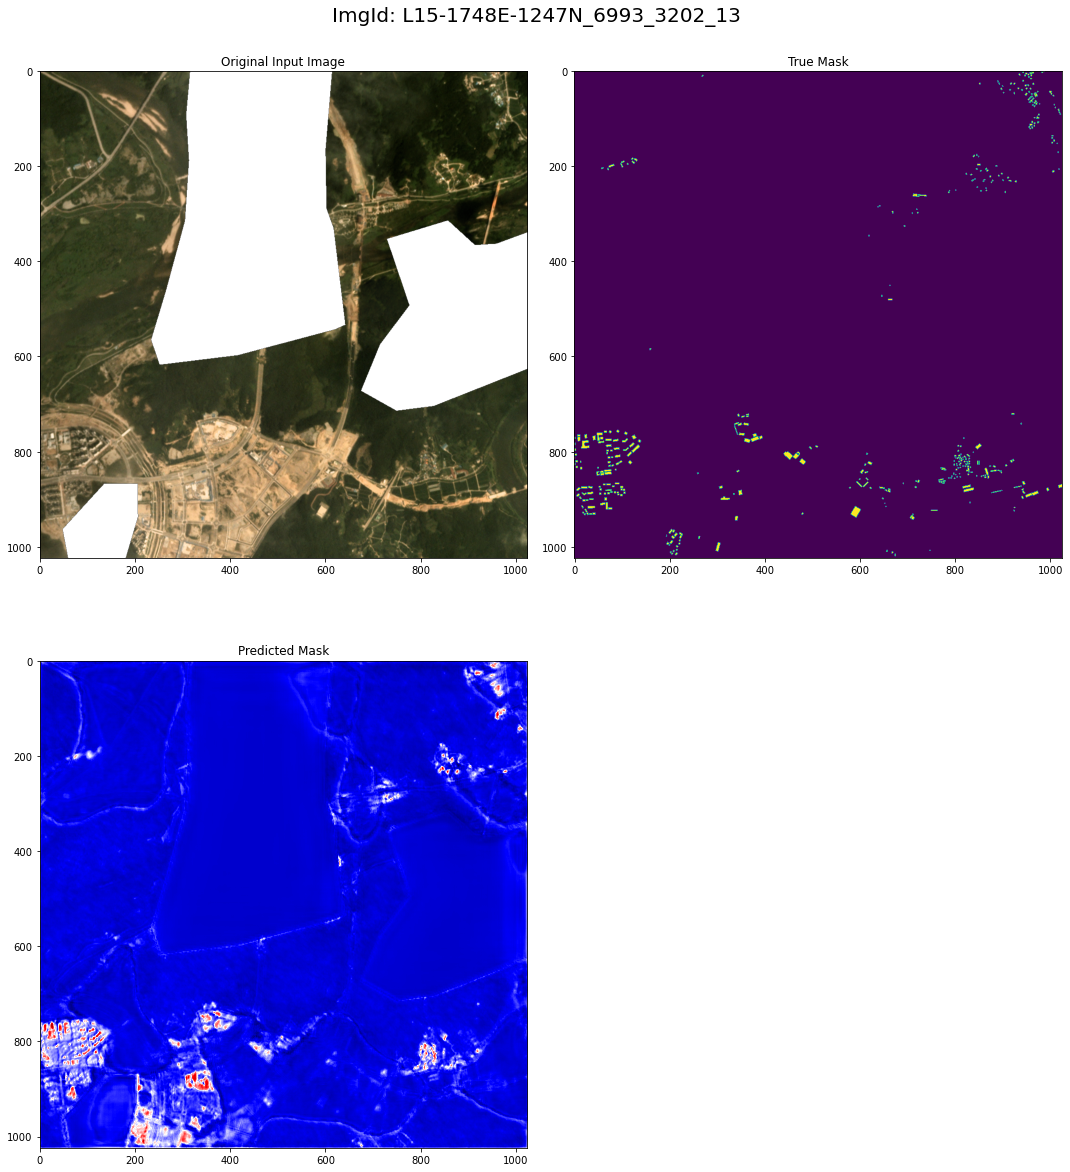

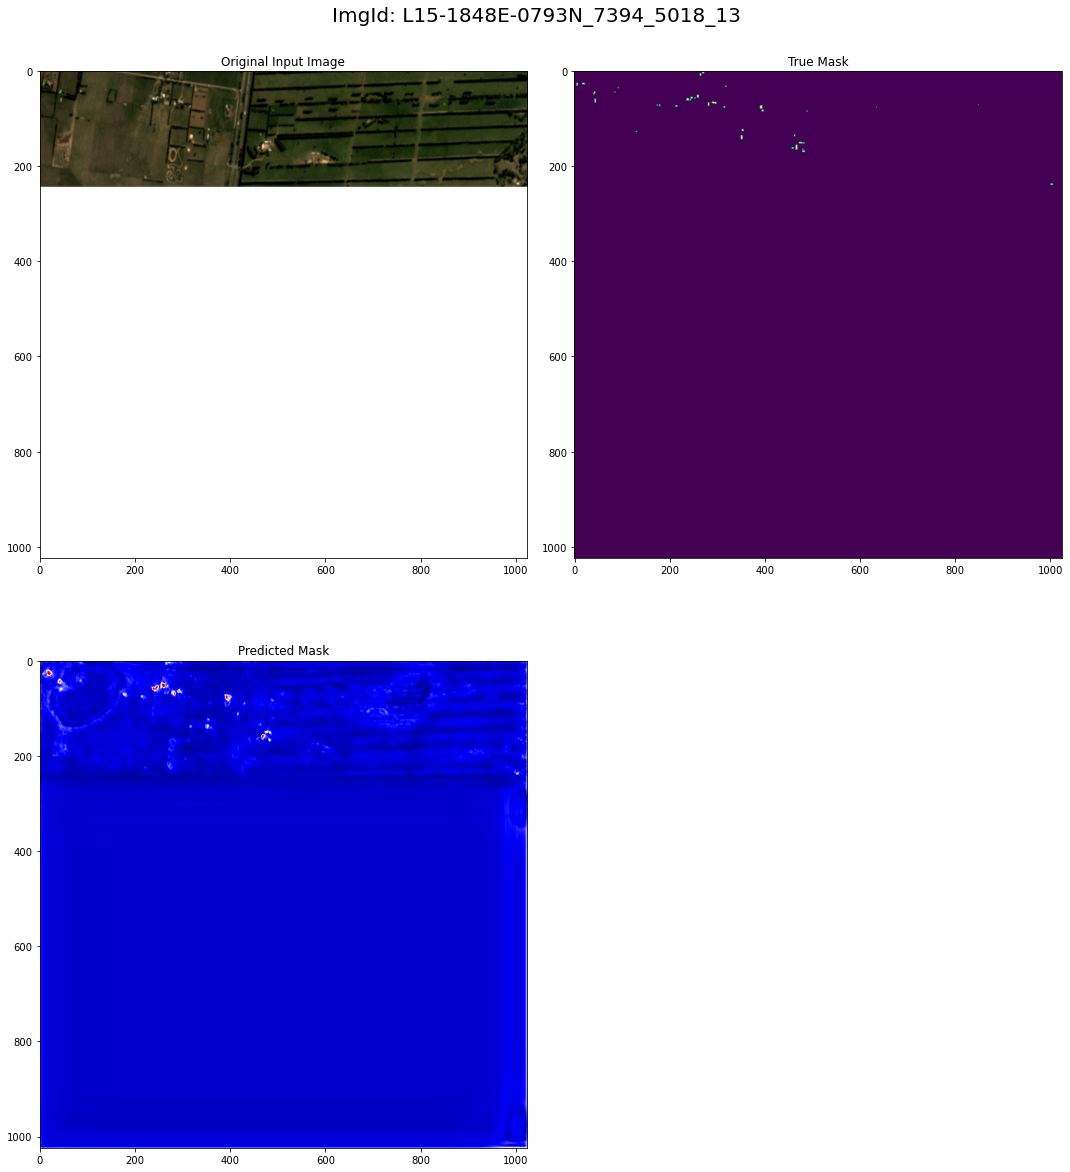

In [14]:
for i in range(len(df_testing)):
    imgId = [df_testing['ImageId'].iloc[i]]
    plot_predictions(imgId)